In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
# Statistical Libraries (for correlation testing)
from sklearn.metrics import confusion_matrix
from scipy.stats import spearmanr
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

matplotlib.rc('font', **{'size' : 16})

In [2]:
DATA = "../preprocessing/standardized_data.csv"
data = pd.read_csv(DATA,header=0)

### Reusing our definitions of misclassification defined in `stage_1`: 

In [3]:
def gender_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been gender misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the ground truth or the result from the API is "unsure", no misclassification
        if gt[i] == 0 or prediction[i] == 0: 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [4]:
def race_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been race misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the subjects is within a cornercase group or the prediction has outputed "not sure", then 
        # no misclassification
        if gt[i] in [0,5] or prediction[i] == 0 : 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [5]:
def age_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been age misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        tolerance = 0 
        # If the subject is a child, tolerance interval equals 5
        if gt[i] <= 10: 
            tolerance = 5
        # For teenagers and pre-young-adults, tolerance is 10
        elif gt[i] <= 25: 
            tolerance = 10
        # For the rest of the population, tolerance is 15
        else: 
            tolerance = 15
            
        if gt[i] - tolerance <= prediction[i] <= gt[i] + tolerance: 
            result[i] = 0
        else: 
            result[i] = 1
    return result

In [6]:
def emotion_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been emotion misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        # If dealing with one of the undefined emotions, set the misclassification bit to 0
        if gt[i] <= 0 or prediction[i] <= 0: 
            result[i] = 0 
        # If emotions don't match, set the misclassification bit to 1
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

# Gender Misclassification

### 1. Effect of Gender

In [7]:
gender_apis = {
    "Clarifai": "clarifai_gender", 
    "Microsoft": "microsoft_gender",
    "Amazon": "amazon_gender",
    "Face++": "face++_gender"
}

In [8]:
print("="*50)
for api in gender_apis: 
    is_misclass = gender_misclassification(data["Gender"], data[gender_apis[api]]) == 1
    is_male = data["Gender"] == 2
    is_female = data["Gender"] == 1
    print(api)
    print("males: {} ({}%)".format(
        len(data[is_misclass & is_male]),
        100 * len(data[is_misclass & is_male])/len(data[is_male])
    ))
    
    print("females: {} ({}%)".format(
        len(data[is_misclass & is_female]),
        100 * len(data[is_misclass & is_female])/len(data[is_female])
    ))
    print("="*50)

Clarifai
males: 48 (3.639120545868082%)
females: 286 (21.075902726602802%)
Microsoft
males: 38 (2.8809704321455647%)
females: 9 (0.6632277081798084%)
Amazon
males: 66 (5.003790750568613%)
females: 33 (2.4318349299926307%)
Face++
males: 38 (2.8809704321455647%)
females: 130 (9.579955784819454%)


In [9]:
data_no_ai = data[data["Origin"] != "AI"]

In [10]:
print("="*50)
for api in gender_apis: 
    is_misclass = gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]]) == 1
    is_male = data_no_ai["Gender"] == 2
    is_female = data_no_ai["Gender"] == 1
    print(api)
    print("males: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_male]),
        100 * len(data_no_ai[is_misclass & is_male])/len(data_no_ai[is_male])
    ))
    
    print("females: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_female]),
        100 * len(data_no_ai[is_misclass & is_female])/len(data_no_ai[is_female])
    ))
    print("="*50)

Clarifai
males: 14 (1.1695906432748537%)
females: 271 (22.014622258326565%)
Microsoft
males: 5 (0.4177109440267335%)
females: 4 (0.3249390739236393%)
Amazon
males: 28 (2.3391812865497075%)
females: 32 (2.5995125913891144%)
Face++
males: 17 (1.4202172096908938%)
females: 116 (9.42323314378554%)


In [11]:
print("="*50)
for api in gender_apis: 
    print(api)
    cor, p = spearmanr(data_no_ai["Gender"], 
          gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Clarifai
correlation -0.32320080632444215
p-value 3.582871846434472e-60
Microsoft
correlation 0.007676179989829112
p-value 0.7053336576567459
Amazon
correlation -0.008245737087072755
p-value 0.6846045189870289
Face++
correlation -0.17549295494861444
p-value 2.9752377716133014e-18


### 2. Effect of Race

In [12]:
# Statistical test with rough input 
print("="*50)
for api in gender_apis: 
    print(api)
    cor, p = spearmanr(data_no_ai["Race"], 
          gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Clarifai
correlation -0.03751030419162399
p-value 0.0645459512478181
Microsoft
correlation -0.031231637045107962
p-value 0.12384562392823842
Amazon
correlation -0.02732763884464401
p-value 0.17817428064470528
Face++
correlation -0.07172324252354226
p-value 0.00040376768180038695


In [13]:
# Statistical test with blacks vs non-blacks
print("="*50)
for api in gender_apis: 
    print(api)
    is_black = [int(x) for x in data_no_ai["Race"] == 2]
    cor, p = spearmanr(is_black, 
          gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Clarifai
correlation 0.05682741095600097
p-value 0.005085699456036527
Microsoft
correlation -0.008778186556210122
p-value 0.6654379550212612
Amazon
correlation 0.05133514039541517
p-value 0.011392843975996042
Face++
correlation 0.15108199957985202
p-value 7.142205912841026e-14


In [14]:
print("="*50)
for api in gender_apis: 
    is_misclass = gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]]) == 1
    is_black = data_no_ai["Race"] == 2
    is_notblack = data_no_ai["Race"] != 2
    is_white = data_no_ai["Race"] == 4
    print(api)
    print("blacks: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_black]),
        100 * len(data_no_ai[is_misclass & is_black])/len(data_no_ai[is_black])
    ))
    
    print("non-blacks: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_notblack]),
        100 * len(data_no_ai[is_misclass & is_notblack])/len(data_no_ai[is_notblack])
    ))
    
    print("="*50)

Clarifai
blacks: 102 (14.613180515759312%)
non-blacks: 183 (10.571923743500866%)
Microsoft
blacks: 2 (0.28653295128939826%)
non-blacks: 7 (0.4043905257076834%)
Amazon
blacks: 26 (3.7249283667621778%)
non-blacks: 34 (1.9641825534373194%)
Face++
blacks: 76 (10.888252148997134%)
non-blacks: 57 (3.292894280762565%)


### 3. Effect of Age

In [15]:
data_no_ai["Age"] < 5

0       False
1       False
2       False
3       False
4       False
        ...  
2424    False
2425    False
2426    False
2427    False
2428    False
Name: Age, Length: 2429, dtype: bool

In [16]:
def categorize_age(age): 
    if age < 10: 
        return 0 
    if age < 20: 
        return 1
    if age < 30: 
        return 2
    if age < 45: 
        return 3
    return 4

In [17]:
discrete_age = np.array([categorize_age(age) for age in data_no_ai["Age"]])

In [18]:
print("="*50)
for api in gender_apis: 
    print(api)
    cor, p = spearmanr(discrete_age, 
          gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Clarifai
correlation -0.09276498307202045
p-value 4.66232805334056e-06
Microsoft
correlation -0.041477617016742796
p-value 0.04094890340017603
Amazon
correlation -0.08314390925557953
p-value 4.0829675991489596e-05
Face++
correlation -0.09134381626144682
p-value 6.513973946658159e-06


In [19]:
print("="*50)
for api in gender_apis: 
    is_misclass = gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]]) == 1
    is_child = discrete_age == 0
    is_teen = discrete_age == 1
    is_young = discrete_age == 2
    is_adult = discrete_age == 3
    is_old = discrete_age == 4
    print(api)
    print("children: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_child]),
        100 * len(data_no_ai[is_misclass & is_child])/len(data_no_ai[is_child])
    ))
    
    print("teen: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_teen]),
        100 * len(data_no_ai[is_misclass & is_teen])/len(data_no_ai[is_teen])
    ))
    print("young: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_young]),
        100 * len(data_no_ai[is_misclass & is_young])/len(data_no_ai[is_young])
    ))
    print("adult: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_adult]),
        100 * len(data_no_ai[is_misclass & is_adult])/len(data_no_ai[is_adult])
    ))
    print("old: {} ({}%)".format(
        len(data_no_ai[is_misclass & is_old]),
        100 * len(data_no_ai[is_misclass & is_old])/len(data_no_ai[is_old])
    ))
    
    print("="*50)

Clarifai
children: 2 (50.0%)
teen: 9 (15.517241379310345%)
young: 223 (13.433734939759036%)
adult: 49 (7.313432835820896%)
old: 2 (5.405405405405405%)
Microsoft
children: 1 (25.0%)
teen: 1 (1.7241379310344827%)
young: 6 (0.3614457831325301%)
adult: 1 (0.14925373134328357%)
old: 0 (0.0%)
Amazon
children: 3 (75.0%)
teen: 6 (10.344827586206897%)
young: 43 (2.5903614457831323%)
adult: 8 (1.1940298507462686%)
old: 0 (0.0%)
Face++
children: 2 (50.0%)
teen: 9 (15.517241379310345%)
young: 102 (6.144578313253012%)
adult: 19 (2.8358208955223883%)
old: 1 (2.7027027027027026%)


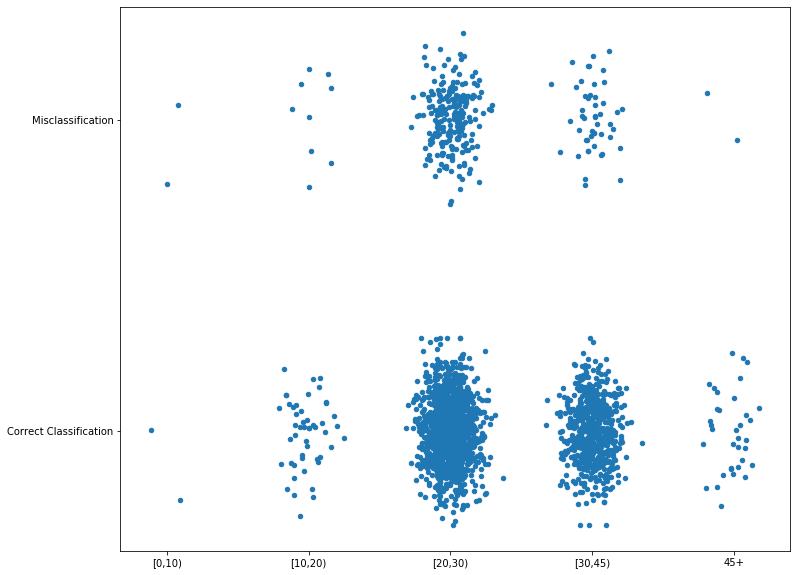

In [20]:
plt.figure(figsize=(12,10)) 
is_misclass = [int(x) for x in gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis['Clarifai']])]
plt.scatter([x + np.random.normal(0, 0.10) for x in discrete_age], 
            [x + np.clip(np.random.normal(0, 0.1), -0.3, 0.3) for x in is_misclass], s = 20)
plt.xticks([0,1,2,3,4], ["[0,10)", "[10,20)", "[20,30)", "[30,45)", "45+"])
plt.yticks([0,1], ["Correct Classification", "Misclassification"])
plt.show()

# 2. Race Misclassification 
Again, only dealing with Clarifai

### 2.1. Effect of Gender

In [21]:
print("AI included")
print("="*50)
is_misclass = race_misclassification(data["Race"], data["clarifai_race"]) == 1
is_male = data["Gender"] == 2
is_female = data["Gender"] == 1
print("Clarifai")
print("males: {} ({}%)".format(
    len(data[is_misclass & is_male]),
    100 * len(data[is_misclass & is_male])/len(data[is_male])
))

print("females: {} ({}%)".format(
    len(data[is_misclass & is_female]),
    100 * len(data[is_misclass & is_female])/len(data[is_female])
))
print("="*50)

AI included
Clarifai
males: 214 (16.224412433661865%)
females: 170 (12.527634487840825%)


In [22]:
print("AI excluded")
print("="*50)
is_misclass = race_misclassification(data_no_ai["Race"], data_no_ai["clarifai_race"]) == 1
is_male = data_no_ai["Gender"] == 2
is_female = data_no_ai["Gender"] == 1
print("Clarifai")
print("males: {} ({}%)".format(
    len(data_no_ai[is_misclass & is_male]),
    100 * len(data_no_ai[is_misclass & is_male])/len(data_no_ai[is_male])
))

print("females: {} ({}%)".format(
    len(data_no_ai[is_misclass & is_female]),
    100 * len(data_no_ai[is_misclass & is_female])/len(data_no_ai[is_female])
))
print("="*50)

AI excluded
Clarifai
males: 177 (14.786967418546366%)
females: 142 (11.535337124289196%)


In [23]:
214/170

1.2588235294117647

In [24]:
177/142

1.2464788732394365

In [25]:
print("Test with AI")
print("="*50)
print("Clarifai")
cor, p = spearmanr(data["Gender"], 
      gender_misclassification(data["Race"], data["clarifai_race"])
     )
print('correlation', cor)
print('p-value', p)
print("="*50)

Test with AI
Clarifai
correlation 0.05392132032581477
p-value 0.0052610127485911455


In [26]:
print("Test without AI")
print("="*50)
print("Clarifai")
cor, p = spearmanr(data_no_ai["Gender"], 
      gender_misclassification(data_no_ai["Race"], data_no_ai["clarifai_race"])
     )
print('correlation', cor)
print('p-value', p)
print("="*50)

Test without AI
Clarifai
correlation 0.04947669125276731
p-value 0.014740546428049964


### 2.2. Effect of Race

In [27]:
print("AI excluded")
print("="*50)
is_misclass = race_misclassification(data_no_ai["Race"], data_no_ai["clarifai_race"]) == 1
is_black = data_no_ai["Race"] == 2
is_white = data_no_ai["Race"] == 4
is_asian = data_no_ai["Race"] == 1
is_latino = data_no_ai["Race"] == 3

print("Clarifai")
print("black: {} ({}%)".format(
    len(data_no_ai[is_misclass & is_black]),
    100 * len(data_no_ai[is_misclass & is_black])/len(data_no_ai[is_black])
))

print("white: {} ({}%)".format(
    len(data_no_ai[is_misclass & is_white]),
    100 * len(data_no_ai[is_misclass & is_white])/len(data_no_ai[is_white])
))

print("asian: {} ({}%)".format(
    len(data_no_ai[is_misclass & is_asian]),
    100 * len(data_no_ai[is_misclass & is_asian])/len(data_no_ai[is_asian])
))
print("latino: {} ({}%)".format(
    len(data_no_ai[is_misclass & is_latino]),
    100 * len(data_no_ai[is_misclass & is_latino])/len(data_no_ai[is_latino])
))

print("="*50)

AI excluded
Clarifai
black: 47 (6.73352435530086%)
white: 187 (16.176470588235293%)
asian: 13 (3.0952380952380953%)
latino: 72 (47.682119205298015%)


In [28]:
print("AI included")
print("="*50)
is_misclass = race_misclassification(data["Race"], data["clarifai_race"]) == 1
is_black = data["Race"] == 2
is_white = data["Race"] == 4
is_asian = data["Race"] == 1
is_latino = data["Race"] == 3

print("Clarifai")
print("black: {} ({}%)".format(
    len(data[is_misclass & is_black]),
    100 * len(data[is_misclass & is_black])/len(data[is_black])
))

print("white: {} ({}%)".format(
    len(data[is_misclass & is_white]),
    100 * len(data[is_misclass & is_white])/len(data[is_white])
))

print("asian: {} ({}%)".format(
    len(data[is_misclass & is_asian]),
    100 * len(data[is_misclass & is_asian])/len(data[is_asian])
))
print("latino: {} ({}%)".format(
    len(data[is_misclass & is_latino]),
    100 * len(data[is_misclass & is_latino])/len(data[is_latino])
))

print("="*50)

AI included
Clarifai
black: 56 (7.5675675675675675%)
white: 201 (16.003184713375795%)
asian: 22 (4.721030042918455%)
latino: 105 (49.76303317535545%)


In [29]:
white_or_latino = [x in [3,4] for x in data["Race"]]

print("Testing white_or_latino vs the rest")
print("="*50)
print("Clarifai")
cor, p = spearmanr(white_or_latino, 
      gender_misclassification(data["Race"], data["clarifai_race"])
     )
print('correlation', cor)
print('p-value', p)
print("="*50)

Testing white_or_latino vs the rest
Clarifai
correlation 0.20046627082160162
p-value 1.1407357744849482e-25


In [30]:
is_misclass = race_misclassification(data["Race"], data["clarifai_race"]) == 1
classified_as_black = data["clarifai_race"] == 1
classified_as_white = data["clarifai_race"] == 4

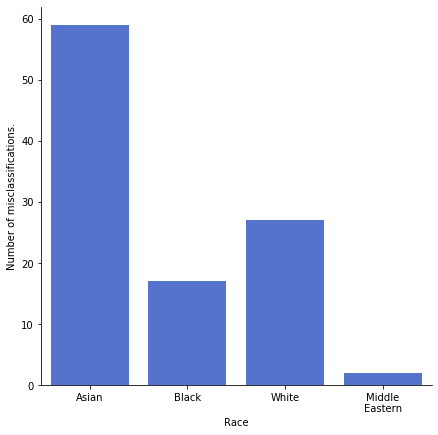

In [31]:
p = sns.catplot(x="clarifai_race", data=data[is_misclass & is_latino][["clarifai_race"]], 
                kind="count", height=6, aspect=1, color="royalblue", label="huge");
p.set_xticklabels(["Asian", "Black", "White", "Middle\nEastern"])
p.set(xlabel='Race', ylabel='Number of misclassifications.')
p.savefig("lat_misclass.svg", format="svg")

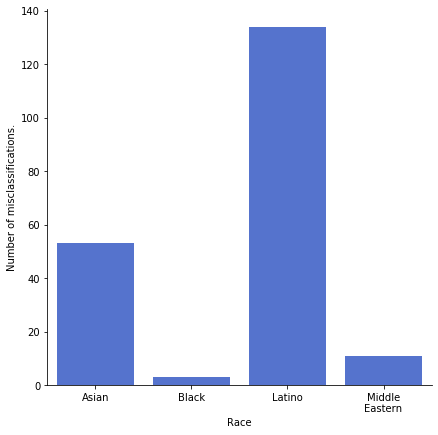

In [32]:
p = sns.catplot(x="clarifai_race", data=data[is_misclass & is_white][["clarifai_race"]], 
                kind="count", height=6, aspect=1, color="royalblue", label="huge");
p.set_xticklabels(["Asian", "Black", "Latino", "Middle\nEastern"])
p.set(xlabel='Race', ylabel='Number of misclassifications.')
p.savefig("white_misclass.svg", format="svg")

### 2.3. Effect of Age

In [33]:
discrete_age = np.array([categorize_age(age) for age in data["Age"]])

In [34]:
print("="*50)
is_misclass = race_misclassification(data["Race"], data["clarifai_race"]) == 1
is_child = discrete_age == 0
is_teen = discrete_age == 1
is_young = discrete_age == 2
is_adult = discrete_age == 3
is_old = discrete_age == 4
print("Clarifai")
print("children: {} ({}%)".format(
    len(data[is_misclass & is_child]),
    100 * len(data[is_misclass & is_child])/len(data[is_child])
))

print("teen: {} ({}%)".format(
    len(data[is_misclass & is_teen]),
    100 * len(data[is_misclass & is_teen])/len(data[is_teen])
))
print("young: {} ({}%)".format(
    len(data[is_misclass & is_young]),
    100 * len(data[is_misclass & is_young])/len(data[is_young])
))
print("adult: {} ({}%)".format(
    len(data[is_misclass & is_adult]),
    100 * len(data[is_misclass & is_adult])/len(data[is_adult])
))
print("old: {} ({}%)".format(
    len(data[is_misclass & is_old]),
    100 * len(data[is_misclass & is_old])/len(data[is_old])
))

print("="*50)

Clarifai
children: 5 (20.833333333333332%)
teen: 25 (20.833333333333332%)
young: 247 (14.195402298850574%)
adult: 100 (13.58695652173913%)
old: 7 (12.280701754385966%)


In [35]:
print("="*50)
print("Clarifai")
cor, p = spearmanr(discrete_age, 
      race_misclassification(data["Race"], data["clarifai_race"])
     )
print('correlation', cor)
print('p-value', p)
print("="*50)

Clarifai
correlation -0.02895977693790358
p-value 0.13413701804181064


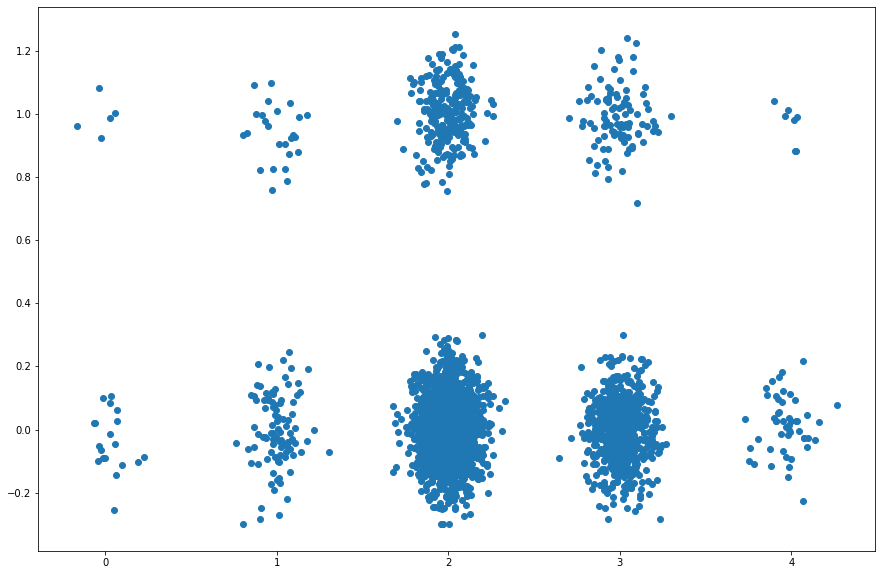

In [36]:
plt.figure(figsize=(15,10)) 
is_misclass = [int(x) for x in race_misclassification(data["Race"], data["clarifai_race"])]
plt.scatter([x + np.random.normal(0, 0.10) for x in discrete_age], 
            [x + np.clip(np.random.normal(0, 0.10), -0.3, 0.3) for x in is_misclass])
plt.show()

# 3. Age Misclassification

In [37]:
age_apis = {
    "Clarifai": "clarifai_age", 
    "Microsoft": "microsoft_age",
    "Amazon": "amazon_age_average",
    "Face++": "face++_age"
}

## 3.1. Effect of Gender

In [38]:
# Note that in this case gender_apis == age_apis --> all the APIs return both
print("="*50)
for api in age_apis: 
    is_misclass = age_misclassification(data["Age"], data[age_apis[api]]) == 1
    is_male = data["Gender"] == 2
    is_female = data["Gender"] == 1
    print(api)
    print("males: {} ({}%)".format(
        len(data[is_misclass & is_male]),
        100 * len(data[is_misclass & is_male])/len(data[is_male])
    ))
    
    print("females: {} ({}%)".format(
        len(data[is_misclass & is_female]),
        100 * len(data[is_misclass & is_female])/len(data[is_female])
    ))
    print("="*50)

Clarifai
males: 265 (20.0909780136467%)
females: 396 (29.18201915991157%)
Microsoft
males: 29 (2.1986353297952994%)
females: 30 (2.210759027266028%)
Amazon
males: 97 (7.354056103108415%)
females: 102 (7.516580692704495%)
Face++
males: 277 (21.00075815011372%)
females: 335 (24.68680913780398%)


In [39]:
print("="*50)
for api in age_apis: 
    is_misclass = age_misclassification(data["Age"], data[age_apis[api]]) == 1
    is_male = data["Gender"] == 2
    is_female = data["Gender"] == 1
    print(api)
    print("males: {} ({}%)".format(
        len(data[is_misclass & is_male]),
        100 * len(data[is_misclass & is_male])/len(data[is_male])
    ))
    
    print("females: {} ({}%)".format(
        len(data[is_misclass & is_female]),
        100 * len(data[is_misclass & is_female])/len(data[is_female])
    ))
    print("="*50)

Clarifai
males: 265 (20.0909780136467%)
females: 396 (29.18201915991157%)
Microsoft
males: 29 (2.1986353297952994%)
females: 30 (2.210759027266028%)
Amazon
males: 97 (7.354056103108415%)
females: 102 (7.516580692704495%)
Face++
males: 277 (21.00075815011372%)
females: 335 (24.68680913780398%)


In [40]:
print("="*50)
for api in gender_apis: 
    print(api)
    cor, p = spearmanr(data_no_ai["Gender"], 
          gender_misclassification(data_no_ai["Gender"], data_no_ai[gender_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Clarifai
correlation -0.32320080632444215
p-value 3.582871846434472e-60
Microsoft
correlation 0.007676179989829112
p-value 0.7053336576567459
Amazon
correlation -0.008245737087072755
p-value 0.6846045189870289
Face++
correlation -0.17549295494861444
p-value 2.9752377716133014e-18


## 3.2. Effect of Race

In [41]:
print("="*50)
for api in age_apis: 
    print("(", api, ")")
    is_misclass = age_misclassification(data["Age"], data[age_apis[api]]) == 1
    is_black = data["Race"] == 2
    print("Misclassified blacks")
    print(len(data[is_misclass & is_black]))
    print(len(data[is_misclass & is_black])/len(data[is_black]))
    print("-"*50)
    print("Misclassified non-blacks")
    print(len(data[is_misclass & ~is_black]))
    print(len(data[is_misclass & ~is_black])/len(data[~is_black]))
    print("="*50)

( Clarifai )
Misclassified blacks
220
0.2972972972972973
--------------------------------------------------
Misclassified non-blacks
441
0.22767165720185856
( Microsoft )
Misclassified blacks
14
0.01891891891891892
--------------------------------------------------
Misclassified non-blacks
45
0.023231801755291687
( Amazon )
Misclassified blacks
74
0.1
--------------------------------------------------
Misclassified non-blacks
125
0.06453278265358803
( Face++ )
Misclassified blacks
132
0.1783783783783784
--------------------------------------------------
Misclassified non-blacks
480
0.24780588538977802


In [42]:
print("="*50)
for api in age_apis: 
    print("(", api, ")")
    is_misclass = age_misclassification(data["Age"], data[age_apis[api]]) == 1
    is_white = data["Race"] == 4
    print("Misclassified whites")
    print(len(data[is_misclass & is_white]))
    print(len(data[is_misclass & is_white])/len(data[is_white]))
    print("-"*50)
    print("Misclassified non-whites")
    print(len(data[is_misclass & ~is_white]))
    print(len(data[is_misclass & ~is_white])/len(data[~is_white]))
    print("="*50)

( Clarifai )
Misclassified whites
301
0.23964968152866242
--------------------------------------------------
Misclassified non-whites
360
0.2533427163969036
( Microsoft )
Misclassified whites
33
0.026273885350318472
--------------------------------------------------
Misclassified non-whites
26
0.018296973961998593
( Amazon )
Misclassified whites
90
0.07165605095541401
--------------------------------------------------
Misclassified non-whites
109
0.07670654468684025
( Face++ )
Misclassified whites
348
0.2770700636942675
--------------------------------------------------
Misclassified non-whites
264
0.18578465869106264


In [43]:
print("="*50)
for api in age_apis: 
    is_misclass = age_misclassification(data["Age"], data[age_apis[api]]) == 1
    is_black = data["Race"] == 2
    is_notblack = data["Race"] != 2
    is_white = data["Race"] == 4
    is_asian = data["Race"] == 1
    is_latino = data["Race"] == 3
    print(api)
    print("black: {} ({}%)".format(
        len(data[is_misclass & is_black]),
        100 * len(data[is_misclass & is_black])/len(data[is_black])
    )) 
    print("white: {} ({}%)".format(
        len(data[is_misclass & is_white]),
        100 * len(data[is_misclass & is_white])/len(data[is_white])
    ))
    print("asian: {} ({}%)".format(
        len(data[is_misclass & is_asian]),
        100 * len(data[is_misclass & is_asian])/len(data[is_asian])
    ))
    print("latino: {} ({}%)".format(
        len(data[is_misclass & is_latino]),
        100 * len(data[is_misclass & is_latino])/len(data[is_latino])
    ))
    
    print("="*50)

Clarifai
black: 220 (29.72972972972973%)
white: 301 (23.96496815286624%)
asian: 100 (21.459227467811157%)
latino: 40 (18.95734597156398%)
Microsoft
black: 14 (1.8918918918918919%)
white: 33 (2.627388535031847%)
asian: 8 (1.7167381974248928%)
latino: 4 (1.8957345971563981%)
Amazon
black: 74 (10.0%)
white: 90 (7.165605095541402%)
asian: 28 (6.008583690987124%)
latino: 7 (3.3175355450236967%)
Face++
black: 132 (17.83783783783784%)
white: 348 (27.70700636942675%)
asian: 87 (18.669527896995707%)
latino: 45 (21.327014218009477%)


In [44]:
print("Statistical test with blacks vs non-blacks")
print("="*50)
for api in age_apis: 
    print(api)
    is_black = [int(x) for x in data["Race"] == 2]
    cor, p = spearmanr(is_black, 
          age_misclassification(data["Age"], data[age_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Statistical test with blacks vs non-blacks
Clarifai
correlation 0.07221108615448824
p-value 0.00018451901893818765
Microsoft
correlation -0.013138249456379583
p-value 0.4968329100055059
Amazon
correlation 0.060468695184202274
p-value 0.0017478409417844049
Face++
correlation -0.07393949875922404
p-value 0.00012863093679325207


In [45]:
print("Statistical test with whites vs non-whites")
print("="*50)
for api in age_apis: 
    print(api)
    is_white = [int(x) for x in data["Race"] == 4]
    cor, p = spearmanr(is_white, 
          age_misclassification(data["Age"], data[age_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Statistical test with whites vs non-whites
Clarifai
correlation -0.015846946038767303
p-value 0.41245256406219033
Microsoft
correlation 0.027115386514944592
p-value 0.16075241307594024
Amazon
correlation -0.009608343169641952
p-value 0.6192508262730387
Face++
correlation 0.10848194578654213
p-value 1.835644501514563e-08


## 3.3. Effect of Age

In [46]:
discrete_age = np.array([categorize_age(age) for age in data["Age"]])

In [47]:
print("="*50)
for api in age_apis: 
    is_misclass = age_misclassification(data["Age"], data[age_apis[api]]) == 1
    is_child = discrete_age == 0
    is_teen = discrete_age == 1
    is_young = discrete_age == 2
    is_adult = discrete_age == 3
    is_old = discrete_age == 4
    print(api)
    print("children: {} ({}%)".format(
        len(data[is_misclass & is_child]),
        100 * len(data[is_misclass & is_child])/len(data[is_child])
    ))
    
    print("teen: {} ({}%)".format(
        len(data[is_misclass & is_teen]),
        100 * len(data[is_misclass & is_teen])/len(data[is_teen])
    ))
    print("young: {} ({}%)".format(
        len(data[is_misclass & is_young]),
        100 * len(data[is_misclass & is_young])/len(data[is_young])
    ))
    print("adult: {} ({}%)".format(
        len(data[is_misclass & is_adult]),
        100 * len(data[is_misclass & is_adult])/len(data[is_adult])
    ))
    print("old: {} ({}%)".format(
        len(data[is_misclass & is_old]),
        100 * len(data[is_misclass & is_old])/len(data[is_old])
    ))
    
    print("="*50)

Clarifai
children: 0 (0.0%)
teen: 26 (21.666666666666668%)
young: 579 (33.275862068965516%)
adult: 42 (5.706521739130435%)
old: 14 (24.56140350877193%)
Microsoft
children: 0 (0.0%)
teen: 19 (15.833333333333334%)
young: 23 (1.3218390804597702%)
adult: 3 (0.4076086956521739%)
old: 14 (24.56140350877193%)
Amazon
children: 0 (0.0%)
teen: 20 (16.666666666666668%)
young: 141 (8.10344827586207%)
adult: 20 (2.717391304347826%)
old: 18 (31.57894736842105%)
Face++
children: 11 (45.833333333333336%)
teen: 63 (52.5%)
young: 401 (23.04597701149425%)
adult: 124 (16.847826086956523%)
old: 13 (22.80701754385965%)


In [48]:
print("="*50)
for api in age_apis: 
    print(api)
    cor, p = spearmanr(discrete_age, 
          age_misclassification(data["Age"], data[age_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Clarifai
correlation -0.218752355968817
p-value 2.3012688112850737e-30
Microsoft
correlation -0.04008418787065421
p-value 0.03809695933372611
Amazon
correlation -0.06365539263716
p-value 0.000983106928421296
Face++
correlation -0.1281502387712838
p-value 2.8365174907954134e-11


# Emotion Misclassification

### Effect of Gender

In [49]:
emotion_apis = {
    "Microsoft": "microsoft_emotion",
    "Amazon": "amazon_emotion",
    "Face++": "face++_emotion"
}

In [50]:
print("="*50)
for api in emotion_apis: 
    print(api)
    cor, p = spearmanr(data_no_ai["Gender"], 
          emotion_misclassification(data_no_ai["Emotion"], data_no_ai[emotion_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Microsoft
correlation 0.02402198576518477
p-value 0.23661809948185683
Amazon
correlation 0.003749052503746514
p-value 0.8534822570780178
Face++
correlation 0.013928279132257613
p-value 0.4926288722682117


### Effect of Race

In [51]:
print("="*50)
for api in emotion_apis: 
    print(api)
    cor, p = spearmanr(data_no_ai["Race"], 
          emotion_misclassification(data_no_ai["Emotion"], data_no_ai[emotion_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Microsoft
correlation 0.05199786777032823
p-value 0.010373504382776502
Amazon
correlation 0.02974396876746619
p-value 0.14278515930122856
Face++
correlation 0.028320286720996613
p-value 0.1629183066441704


In [52]:
is_black = data_no_ai["Race"] == 2
is_white = data_no_ai["Race"] == 4
is_asian = data_no_ai["Race"] == 1
is_latino = data_no_ai["Race"] == 3

for api in emotion_apis:
    print("="*50)
    print(api)
    print("-"*50)
    
    em_mis = [x == 1 for x in emotion_misclassification(data_no_ai["Emotion"], data_no_ai[emotion_apis[api]])]
    print("Black misclassification rate: ")
    print(sum(em_mis & is_black)/sum(is_black))
    print("White misclassification rate: ")
    print(sum(em_mis & is_white)/sum(is_white))
    print("Asian misclassification rate: ")
    print(sum(em_mis & is_asian)/sum(is_asian))
    print("Latino misclassification rate: ")
    print(sum(em_mis & is_latino)/sum(is_latino))
    

Microsoft
--------------------------------------------------
Black misclassification rate: 
0.23925501432664756
White misclassification rate: 
0.19982698961937717
Asian misclassification rate: 
0.09523809523809523
Latino misclassification rate: 
0.046357615894039736
Amazon
--------------------------------------------------
Black misclassification rate: 
0.2134670487106017
White misclassification rate: 
0.1903114186851211
Asian misclassification rate: 
0.1357142857142857
Latino misclassification rate: 
0.07947019867549669
Face++
--------------------------------------------------
Black misclassification rate: 
0.335243553008596
White misclassification rate: 
0.2958477508650519
Asian misclassification rate: 
0.22380952380952382
Latino misclassification rate: 
0.15894039735099338


In all cases blacks and whites seem to be misclassified more often than Latino and Asian subjects. However, this is probably due to the fact they dominate the "*harder*" datasets - NimStim and CFD, which exhibit non-standard emotions. 

In [53]:
data.query("Origin=='NimStim'")["Race"].value_counts()

4    404
2    159
1     94
3     16
Name: Race, dtype: int64

In [54]:
data.query("Origin=='CFD'")["Race"].value_counts()

2    526
4    464
1    109
3    108
Name: Race, dtype: int64

### Effect of Age

In [55]:
discrete_age = np.array([categorize_age(age) for age in data_no_ai["Age"]])

In [56]:
print("="*50)
for api in emotion_apis: 
    print(api)
    cor, p = spearmanr(discrete_age, 
          emotion_misclassification(data_no_ai["Emotion"], data_no_ai[emotion_apis[api]])
         )
    print('correlation', cor)
    print('p-value', p)
    print("="*50)

Microsoft
correlation -0.004997408236234161
p-value 0.8055495114502442
Amazon
correlation -0.016229304408883018
p-value 0.42400034179018364
Face++
correlation -0.02578357552563898
p-value 0.20397862289385604
